Experiments for setting up prototypical networks

In [2]:
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from sklearn import mixture

In [3]:
sns.set(color_codes=True)

In [4]:
COMPUTE_ENGINE_SRC_PATH = "../"

if COMPUTE_ENGINE_SRC_PATH not in sys.path:
    sys.path.append(COMPUTE_ENGINE_SRC_PATH)
else:
    print("Path='{0}' already in system path ".format(COMPUTE_ENGINE_SRC_PATH))

In [5]:
from compute_engine.src.utils import load_data_file
from compute_engine.src.utils import make_data_array

In [6]:
INFO="INFO: "

### Load the data

In [7]:
# TUF region data
wga_mu_tuf_file = "../data/train/wga_windows_mean_0_TUF_I_CHR_1_MEAN_CUTOFF.txt"
nowga_mu_tuf_file = "../data/train/no_wga_windows_mean_0_TUF_I_CHR_1_MEAN_CUTOFF.txt"

# single copy deletion data
wga_mu_single_copy_del_file = "../data/train/wga_windows_mean_0_SINGLE_COPY_DELETION_CHR_2_MEAN_CUTOFF.txt"
nowga_mu_single_copy_del_file = "../data/train/no_wga_windows_mean_0_SINGLE_COPY_DELETION_CHR_2_MEAN_CUTOFF.txt"

# duplication data
wga_mu_duplication_file = "../data/train/wga_windows_mean_0_DUPLICATION_CHR_1_MEAN_CUTOFF.txt"
nowga_mu_duplication_file = "../data/train/no_wga_windows_mean_0_DUPLICATION_CHR_1_MEAN_CUTOFF.txt"

# full copy deletion data
wga_mu_del_file = "../data/train/wga_windows_mean_0_DELETE_CHR_1_MEAN_CUTOFF.txt"
nowga_mu_del_file = "../data/train/no_wga_windows_mean_0_DELETE_CHR_1_MEAN_CUTOFF.txt"

In [8]:
wga_mu_tuf = load_data_file(filename=wga_mu_tuf_file, type_convert="FLOAT")
nowga_mu_tuf = load_data_file(filename=nowga_mu_tuf_file, type_convert="FLOAT")

assert len(wga_mu_tuf) == len(nowga_mu_tuf), "Invalid data size for TUF data"

wga_mu_single_copy_del = load_data_file(filename=wga_mu_single_copy_del_file, 
                                             type_convert="FLOAT")
nowga_mu_single_copy_del = load_data_file(filename=nowga_mu_single_copy_del_file, 
                                                type_convert="FLOAT")

assert len(wga_mu_single_copy_del) == len(nowga_mu_single_copy_del), \
"Invalid data size for single copy deletion data"

wga_mu_duplication = load_data_file(filename=wga_mu_duplication_file, type_convert="FLOAT")
nowga_mu_duplication = load_data_file(filename=nowga_mu_duplication_file, type_convert="FLOAT")

assert len(wga_mu_duplication) == len(nowga_mu_duplication), "Invalid data size for duplication data"

wga_mu_del = load_data_file(filename=wga_mu_del_file, type_convert="FLOAT")
nowga_mu_del = load_data_file(filename=nowga_mu_del_file, type_convert="FLOAT")

assert len(wga_mu_del) == len(nowga_mu_del), "Invalid data size for full deletion data"

### Mix the data

In [9]:

# WGA sample
wga_mu = []
wga_mu.extend(wga_mu_single_copy_del)
wga_mu.extend(wga_mu_duplication)
wga_mu.extend(wga_mu_del)


# NO-WGA sample
no_wga_mu = []
no_wga_mu.extend(nowga_mu_single_copy_del)
no_wga_mu.extend(nowga_mu_duplication)
no_wga_mu.extend(nowga_mu_del)

### Cluster the reference data

#### Options for GMM clustering

In [10]:
NUM_CLUSTERS=5
COVARIANCE_TYPE = 'diag'
MAX_ITRS=1000
TOL=1.0e-5
N_INIT=1
TUF_NUM_CLUSTERS=3
COLORS = np.array(['green', 'blue', 'red',
                   'yellow', 'pink', 'orange', 
                   'purple', 'navy', 'brown'])

# add black color for outliers (if any)
COLORS = np.append(COLORS, ["#000000"])

SAVE_DATA_PATH = "/home/alex/qi3/hmmtuf/data/prototypical_nets/"
SAVE_FILENAME = "prototypical_tuf.csv"

### GMM clustering

In [11]:
# Dictionay that holds the states for the HMM 
states={}

In [12]:
data = make_data_array(wga_mu=wga_mu, 
                       no_wga_mu=no_wga_mu, gc=None, 
                       use_ratio=False, use_gc=False)

data = np.array(data)

assert data.shape == (len(wga_mu), 2)

In [13]:
# the GMM cluster
gmm = mixture.GaussianMixture(n_components=NUM_CLUSTERS,
                              covariance_type=COVARIANCE_TYPE,
                              tol=TOL, max_iter=MAX_ITRS, n_init=N_INIT)

# fit the data
gmm.fit(data)
   

GaussianMixture(covariance_type='diag', max_iter=1000, n_components=5,
                tol=1e-05)

In [14]:
print("Converged: ", gmm.converged_)
print("BIC: ", gmm.bic(data))    

Converged:  True
BIC:  162882.30627755844


In [15]:
labels = gmm.predict(data)
print("{0} Number of labels= {1}".format(INFO, len(labels)))

INFO:  Number of labels= 11915


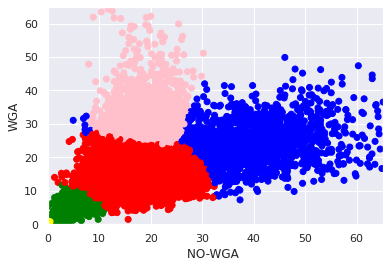

In [16]:
xlim=(0., 65.0)
ylim=(0., 65.0)

colors = COLORS[labels]

plt.scatter(no_wga_mu, wga_mu, color=colors)
plt.xlabel("NO-WGA ")
plt.ylabel("WGA")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()


In [17]:
# map that holds the association between the
# component color and component index

color_comp_assoc = {}
for label, color in zip(labels, colors):
    if color in color_comp_assoc.keys():
        assert color_comp_assoc[color][0] == label
        color_comp_assoc[color][1] += 1
    else:
        color_comp_assoc[color] = [label, 1]
        
print("{0} Color-Component association: {1}".format(INFO, color_comp_assoc))

INFO:  Color-Component association: {'red': [2, 7604], 'blue': [1, 1551], 'pink': [4, 1897], 'green': [0, 485], 'yellow': [3, 378]}


In [18]:
means = gmm.means_

for i in range(len(means)):
    print("{0} Component {1} mu's {2} ".format(INFO, i , means[i]))

INFO:  Component 0 mu's [4.73829469 4.54374151] 
INFO:  Component 1 mu's [36.2668105  24.47551781] 
INFO:  Component 2 mu's [17.91849801 15.7008048 ] 
INFO:  Component 3 mu's [0.07647948 0.13422081] 
INFO:  Component 4 mu's [19.29473303 27.15943181] 


In [19]:
csv_data = {"Duplicate": 1, 'Full-Delete': 3, 'Normal-1': 2, "Normal-2": 4, "Single-Delete": 0 }

### Cluster for TUF

In [20]:
tuf_wga_mu = []
tuf_wga_mu.extend(wga_mu_tuf)

tuf_nowga_mu = []
tuf_nowga_mu.extend(nowga_mu_tuf)

In [21]:
tuf_data = make_data_array(wga_mu=tuf_wga_mu, 
                           no_wga_mu=tuf_nowga_mu, gc=None, 
                           use_ratio=True, use_gc=False)

tuf_data = np.array(tuf_data)

assert tuf_data.shape == (len(tuf_wga_mu), 3)

In [22]:
# the GMM cluster
tuf_gmm = mixture.GaussianMixture(n_components=TUF_NUM_CLUSTERS,
                                  covariance_type=COVARIANCE_TYPE,
                                  tol=TOL, 
                                  max_iter=MAX_ITRS, n_init=N_INIT)

# fit the data
tuf_gmm.fit(tuf_data)

GaussianMixture(covariance_type='diag', max_iter=1000, n_components=3,
                tol=1e-05)

In [23]:
print("{0} Converged={1} ".format(INFO, tuf_gmm.converged_))
print("BIC: ", tuf_gmm.bic(tuf_data))  

INFO:  Converged=True 
BIC:  16196.756568592093


In [24]:
tuf_labels = tuf_gmm.predict(tuf_data)
print("{0} Number of labels= {1}".format(INFO, len(tuf_labels)))

INFO:  Number of labels= 1260


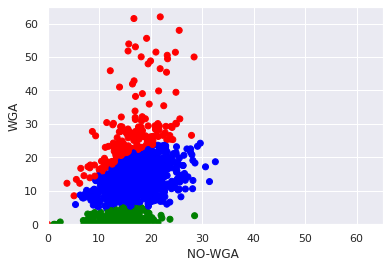

In [25]:
xlim=(0., 65.0)
ylim=(0., 65.0)

colors = COLORS[tuf_labels]

plt.scatter(tuf_nowga_mu, tuf_wga_mu, color=colors)
plt.xlabel("NO-WGA ")
plt.ylabel("WGA")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()


In [26]:
# map that holds the association between the
# component color and component index

tuf_color_comp_assoc = {}
for label, color in zip(tuf_labels, colors):
    if color in tuf_color_comp_assoc.keys():
        assert tuf_color_comp_assoc[color][0] == label
        tuf_color_comp_assoc[color][1] += 1
    else:
        tuf_color_comp_assoc[color] = [label, 1]

print("{0} TUF Color-cluster association={1}".format(INFO, tuf_color_comp_assoc))

INFO:  TUF Color-cluster association={'red': [2, 193], 'blue': [1, 882], 'green': [0, 185]}


In [27]:
csv_data_tuf = {'TUF': 0}

### Save the data

In [32]:
with open(SAVE_DATA_PATH + SAVE_FILENAME, 'w', newline='\n') as csvfile:
    csv_writer = csv.writer(csvfile, delimiter=',')
    
    # write the data for 
    for item in csv_data:
        name = item
        label = csv_data[item]
        
        
        for idx in range(len(labels)):
            if labels[idx] == label:
            
                row = [data[idx][0], data[idx][1] , name]
                csv_writer.writerow(row)
    
    # write the data for TUF
    for item in csv_data_tuf:
        name = item
        label= csv_data_tuf[item]
        
        
        for idx in range(len(tuf_labels)):
            if tuf_labels[idx] == label:
            
                row = [tuf_data[idx][0], tuf_data[idx][1] , name]
                csv_writer.writerow(row)
    
    